Processing Field Capacity - FC (mm/mm)...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Value range: 0.0863 to 0.5545
Processing Wilting Point - WP (mm/mm)...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Value range: 0.0258 to 0.3780
Processing Available Water Capacity - AWC (mm/mm)...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Value range: 0.0000 to 0.3580
Processing Effective Plant Rooting Depth (m)...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


  Value range: 0.0000 to 126.1100
Processing Water Holding Capacity - WHC (mm)...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


  Value range: 0.0000 to 18526.4609


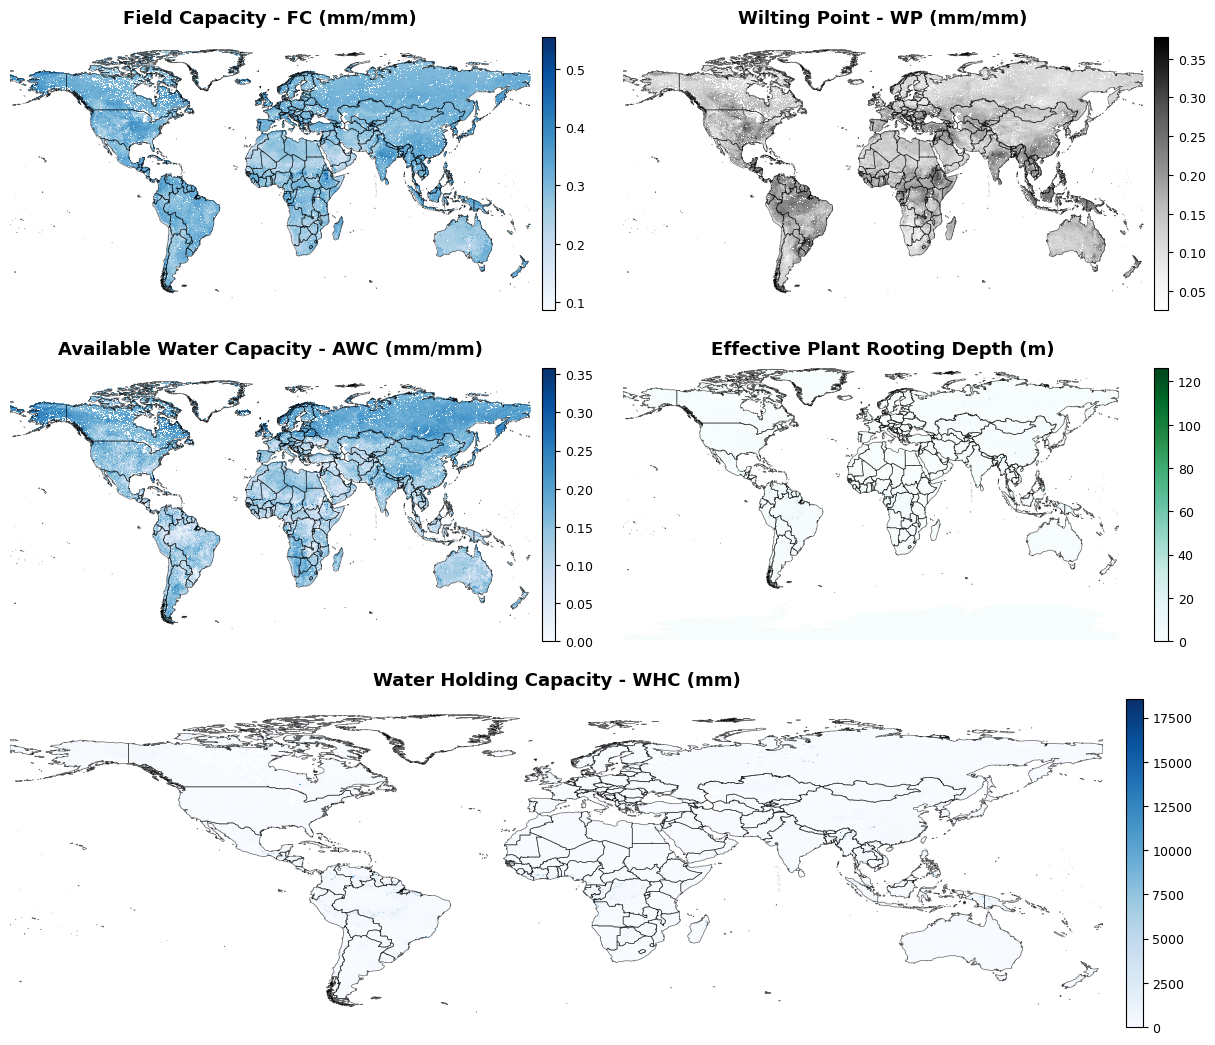

In [29]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import numpy as np
from rasterio.enums import Resampling
from affine import Affine

def load_and_resample_raster(path, max_pixels=2048 * 2048):
    """Load and resample raster to avoid memory issues."""
    with rasterio.open(path) as src:
        width = src.width
        height = src.height
        total_pixels = width * height
        
        # Compute scale factor
        scale = 1.0
        if total_pixels > max_pixels:
            scale = (max_pixels / float(total_pixels)) ** 0.5
        
        out_width = max(1, int(width * scale))
        out_height = max(1, int(height * scale))
        
        # Read downsampled band
        data = src.read(
            1,
            out_shape=(out_height, out_width),
            resampling=Resampling.nearest
        )
        
        # Adjust transform
        new_transform = src.transform * Affine.scale(
            (width / out_width), 
            (height / out_height)
        )
        
        # Get nodata value
        nodata = src.nodata
        
        return data, new_transform, nodata

""" def get_robust_vmin_vmax(data, nodata=None, percentile_range=(1, 99)):
    """"""Calculate robust min/max values excluding nodata.""""""
    # Mask nodata values
    if nodata is not None:
        valid_mask = data != nodata
    else:
        valid_mask = ~np.isnan(data)
    
    valid_data = data[valid_mask]
    
    if len(valid_data) == 0:
        return 0, 1
    
    # Use percentiles for robust range
    vmin, vmax = np.percentile(valid_data, percentile_range)
    
    # Ensure vmin != vmax
    if vmin == vmax:
        vmin = valid_data.min()
        vmax = valid_data.max()
        if vmin == vmax:
            vmax = vmin + 1
    
    return vmin, vmax """

def get_robust_vmin_vmax(data, nodata=None, percentile_range=(1, 99)):
    """Calculate robust min/max values excluding nodata."""
    # Mask nodata values
    if nodata is not None:
        valid_mask = data != nodata
    else:
        valid_mask = ~np.isnan(data)
    
    valid_data = data[valid_mask]
    
    if len(valid_data) == 0:
        return 0, 1
    
    # Use percentiles for robust range
    #vmin, vmax = np.percentile(valid_data, percentile_range)
    vmin, vmax = valid_data.min(), valid_data.max()
    
    # Ensure vmin != vmax
    if vmin == vmax:
        vmin = valid_data.min()
        vmax = valid_data.max()
        if vmin == vmax:
            vmax = vmin + 1
    
    return vmin, vmax

def plot_raster_with_boundaries(ax, data, transform, nodata, cmap, world, title):
    """Plot raster with world boundaries and proper value range."""
    # Get robust value range
    vmin, vmax = get_robust_vmin_vmax(data, nodata)
    
    # Mask nodata for display
    masked_data = np.ma.masked_equal(data, nodata) if nodata is not None else data
    
    # Display raster
    im = ax.imshow(
        masked_data,
        extent=[transform[2], transform[2] + transform[0] * data.shape[1],
                transform[5] + transform[4] * data.shape[0], transform[5]],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation='nearest',
        aspect='auto'
    )
    
    # Add world boundaries (excluding Antarctica)
    world.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.6)
    
    # Set title only
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    
    # Remove axis labels and ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove frame/spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Set aspect ratio to match data
    ax.set_aspect('auto')
    
    return im, vmin, vmax

def add_colorbar(fig, ax, im, vmin, vmax):
    """Add vertical colorbar with proper formatting."""
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', 
                       pad=0.02, fraction=0.046, aspect=20)
    
    cbar.ax.tick_params(labelsize=9)
    
    # Format colorbar labels
    if vmax - vmin < 1:
        cbar.ax.ticklabel_format(style='plain', useOffset=False)
    
    return cbar

# Main execution
def main():
    # Load world boundaries
    world = gpd.read_file("Z:\\PhD_Datasets&Analysis\\Info_Inputs\\Reference_Layers\\World_Countries_Generalized_WGS84.shp")
    
    # Filter out Antarctica
    # Try different possible column names for continent
    if 'CONTINENT' in world.columns:
        world = world[world['CONTINENT'] != 'Antarctica']
    elif 'continent' in world.columns:
        world = world[world['continent'] != 'Antarctica']
    elif 'Continent' in world.columns:
        world = world[world['Continent'] != 'Antarctica']
    else:
        # If no continent column, filter by country name
        if 'COUNTRY' in world.columns:
            world = world[world['COUNTRY'] != 'Antarctica']
        elif 'Country' in world.columns:
            world = world[world['Country'] != 'Antarctica']
        elif 'NAME' in world.columns:
            world = world[world['NAME'] != 'Antarctica']
        elif 'name' in world.columns:
            world = world[world['name'] != 'Antarctica']
    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(13, 11))
    gs = GridSpec(3, 2, figure=fig, hspace=0.2, wspace=0.1, 
                  height_ratios=[1, 1, 1.2],
                  left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    # Define data
    geotiff_paths = [
        'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\SoilGrids\\Vol_Water_Content\\33kPa\\FC33_WGS84.tif',
        'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\SoilGrids\\Vol_Water_Content\\1500kPa\\WP_WGS84.tif',
        'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\SoilGrids\\AWC_Standard_Method\\Only_Positive_Values\\AWC_FC33_WGS84.tif',
        'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\Global_effective_plant_rooting_depth\\data\\Effective_Rooting_Depth_With_Zeros_Clipped.tif',
        'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\Water_Holding_Capacity\\WHC_FC33_WGS84.tif'
    ]
    
    names = [
        'Field Capacity - FC (mm/mm)',
        'Wilting Point - WP (mm/mm)',
        'Available Water Capacity - AWC (mm/mm)',
        'Effective Plant Rooting Depth (m)',
        'Water Holding Capacity - WHC (mm)'
    ]
    
    colormaps = ['Blues', 'Greys', 'Blues', 'BuGn', 'Blues']
    
    # Create subplots
    axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, :])
    ]
    
    # Plot each raster
    for idx, (ax, path) in enumerate(zip(axes, geotiff_paths)):
        print(f"Processing {names[idx]}...")
        
        # Load and resample raster
        data, transform, nodata = load_and_resample_raster(path)
        
        # Plot raster with boundaries
        im, vmin, vmax = plot_raster_with_boundaries(
            ax, data, transform, nodata, 
            colormaps[idx], world, names[idx]
        )
        
        # Add vertical colorbar for all maps
        add_colorbar(fig, ax, im, vmin, vmax)
        
        print(f"  Value range: {vmin:.4f} to {vmax:.4f}")
    
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()